# Group: CopyPaste
#### Dataset used: Dataset_Hospital_Vists.csv, test.csv
#### Participants: Ligia, Gina, Raza

### Contents Draft

1. Problem and Goal Definition
2. Data Understanding
3. Data Quality Check
4. Exploratory Data Analysis
5. Data Cleaning and Preprocessing
6. Train-Test Split
7. Model Building
8. Model Evaluation
9. Model Interpretation
10. Fine-Tuning and Optimization

### 1. Problem and Goal Definition
Problem: Patients in a hospital miss their scheduled appointments.

Goal: Develop a machine learning model that predicts if a patient will miss a future appointment.

### 2. Data Understanding
#### 2.1 Dataset Description

- The dataset is at appointment level granularity and contains detail of each appointment and patient.

- It has 14 columns of which 1 will be our target variable: No-show.

- We mostly have information about an appointment's date and place and the patients' health details. A column also shows if a patient received an SMS before the appointment.

#### 2.2 Quick Analysis from Kaggle

- There is missing data in the columns Age, Community, Social Welfare, and some diseases.
- Female to Male ratio is 65:35.
- We have no NULLs in the target variable.
- For Handcap, we have multiple values even though it seems to be a binary variable.

### 3. Data Quality Check

- Uniqueness
- Missing data
- Data type consistency check
- Distribution of Categorical Variables
- Dates inconsistency

In [1]:
# Setting up environment with packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Importing the dataset

df = pd.read_csv("/Users/muhammadraza/Documents/GitHub/BIPM/Data Science/Project/Dataset_Hospital_Visits.csv")
df.head()

# Increase seaborn default resolution
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set(rc={'figure.figsize':(5,6)})

# Give variables to color numbers

green = '#008000'
red = '#ff0000'


In [3]:
## Uniqueness

# Is each row unique?

print("Duplicate rows: " + str(df.duplicated().sum()))

# Is each appointmentID unique?

print("Duplicate appointments: " + str(df['AppointmentID'].duplicated().sum()))

Duplicate rows: 0
Duplicate appointments: 0


We can conclude that the dataset only containts unique IDs and no duplicates.

In [4]:
## Missing Data

# Which columns have missing data?

missing_data = df.isnull().sum()
total_entries = len(df)
percentage_missing = round((missing_data / total_entries) * 100, 2)

missing_info = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage Missing': percentage_missing
})

print(missing_info)

                 Missing Count  Percentage Missing
PatientId                    0                0.00
AppointmentID                0                0.00
Sex                          0                0.00
ScheduledDate                0                0.00
AppointmentDate              0                0.00
Age                       8807                9.96
Community                10713               12.12
SocialWelfare            12519               14.16
Hipertension              8021                9.07
Diabetes                     0                0.00
Alcoholism               14889               16.84
Handcap                      0                0.00
SMS_received                 0                0.00
No-show                      0                0.00


As seen from Kaggle, Age, Community, SocialWelfare, Hipertension, and Alcoholism have significant null values.

In [5]:
## Data Type Consistency

df.dtypes

PatientId          float64
AppointmentID        int64
Sex                 object
ScheduledDate       object
AppointmentDate     object
Age                float64
Community           object
SocialWelfare       object
Hipertension        object
Diabetes            object
Alcoholism          object
Handcap             object
SMS_received        object
No-show             object
dtype: object

1. PatientId and Age are to be converted to int from float as IDs must be int/str and ages are usually considered in whole number terms.
2. ScheduledDate and AppointmentDate must be timestamps and not objects.

In [6]:
# Distribution of Categorical Variables

occ = df.groupby('Handcap').size().reset_index()
print(occ)

  Handcap      0
0       2    139
1       3     11
2       4      3
3      no  86626
4     yes   1642


We assume that this column was meant to be a binary column and the numerical values are bad data. They will be removed during data cleaning.

In [7]:
# Dates inconsistency

from datetime import datetime

df['AppointmentDate'] = df['AppointmentDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').date())
df['ScheduledDate'] = df['ScheduledDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').date())

counts = df['ScheduledDate'] > df['AppointmentDate']
occurrence_counts = counts.value_counts()

print(occurrence_counts)

False    88417
True         4
Name: count, dtype: int64


We see that we have 4 incoherent combination of schedule and appointment dates - they will be taken out in data cleaning stage.

### 4. Exploratory Data Analysis

- Distribution of the target variable.
- Distribution of age. Which age groups account for the most missing appointments?
- Do patients of a certain community miss their appointments more than others?
- Do males or females miss more appointments?

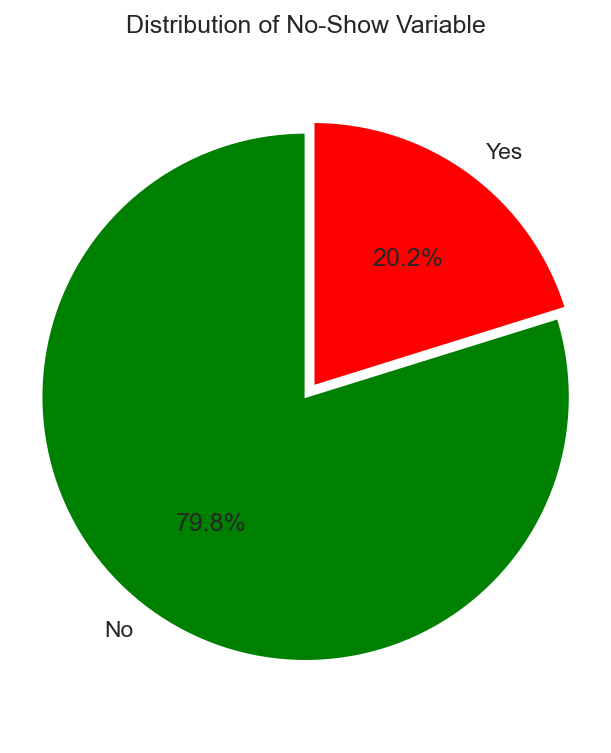

In [8]:
## Distribution of the target variable

value_counts = df['No-show'].value_counts()

labels = value_counts.index
sizes = value_counts.values

colors = [green,red]  # Customize colors
explode = (0.05, 0)  # Explode the 1st slice

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=explode)

plt.title('Distribution of No-Show Variable')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

plt.show()

1 in 5 appointments are missed on average.

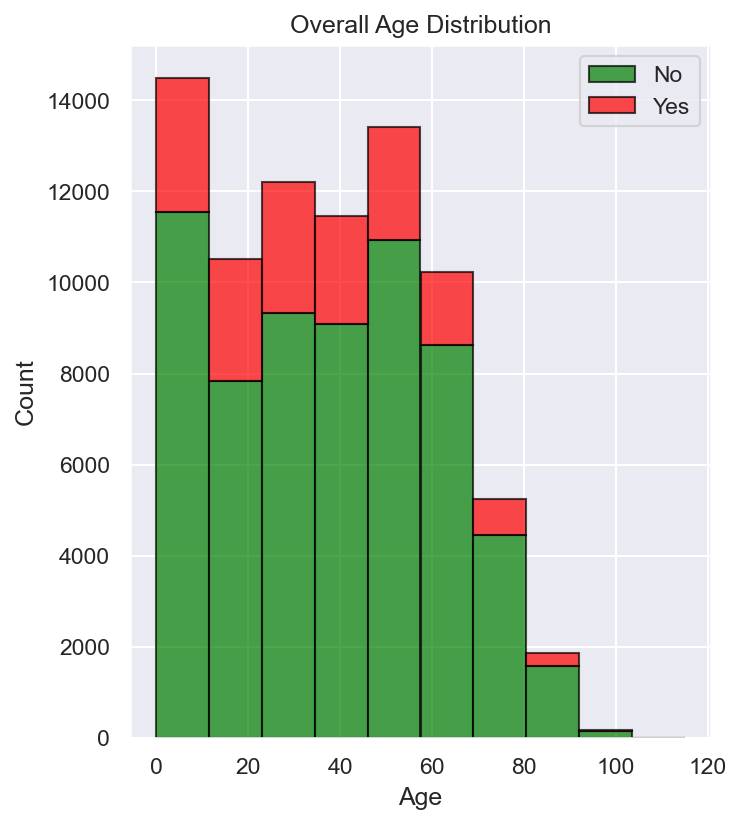

In [9]:
# Which age group misses more appointments?

# Plot histogram with split bars

plt.hist([df[df['No-show'] == 'No']['Age'], df[df['No-show'] == 'Yes']['Age']],
         bins=10, color=['green', 'red'], alpha=0.7, edgecolor='black', label=['No', 'Yes'], stacked=True)

plt.title('Overall Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()

# To add % later:

# n, bins, _ = plt.hist([df[df['No-show'] == 'No']['Age'], df[df['No-show'] == 'Yes']['Age']],
#          bins=10, color=['green', 'red'], alpha=0.7, edgecolor='black', label=['No', 'Yes'], stacked=True)

# for i in range(len(bins) - 1):
#     total = n[0][i] + n[1][i]
#     plt.text((bins[i] + bins[i + 1]) / 2, total, f'{n[0][i] / total:.0%}', ha='center', va='bottom')
#     plt.text((bins[i] + bins[i + 1]) / 2, total, f'{n[1][i] / total:.0%}', ha='center', va='top')

plt.show()

There is an even distribution of the ratio of appointments missed in the various age groups. This tends to change after age 70 where appointments are missed a lot less.

This could be explained by the fact that older people cannot afford to miss appointments due to more serious health issues and due to the fact that they might have more time on their hand.

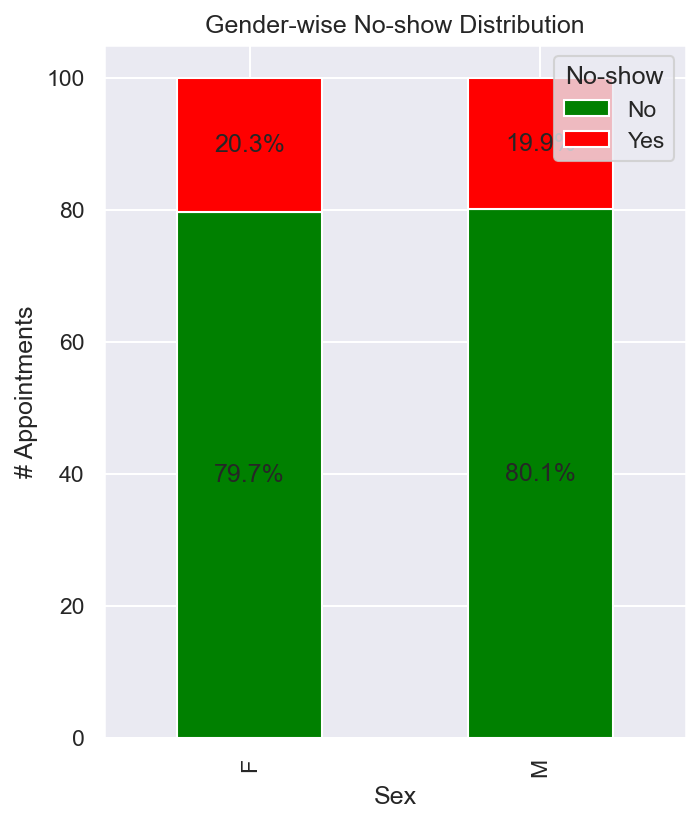

In [10]:
## Which gender misses more appointments?

# Group by 'gender' and 'no_show' and count occurrences
grouped_data = df.groupby(['Sex', 'No-show']).size().unstack()

# Calculate percentages
percentages = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

# Plotting a grouped bar chart
ax = percentages.plot(kind='bar', stacked=True, color=[green, red])

# Annotate bars with percentages
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.title('Gender-wise No-show Distribution')
plt.xlabel('Sex')
plt.ylabel('# Appointments')
plt.legend(title='No-show', loc='upper right')

plt.show()

There seems to be 1 in 5 appointments missed for both genders.

/var/folders/1z/kkxxkq_90qldq3ngyx1pj0fr0000gn/T/ipykernel_64289/2128642182.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  appointments_per_community_show_up = sorted_df.groupby(['Community', 'No-show']).size().unstack(fill_value=0)


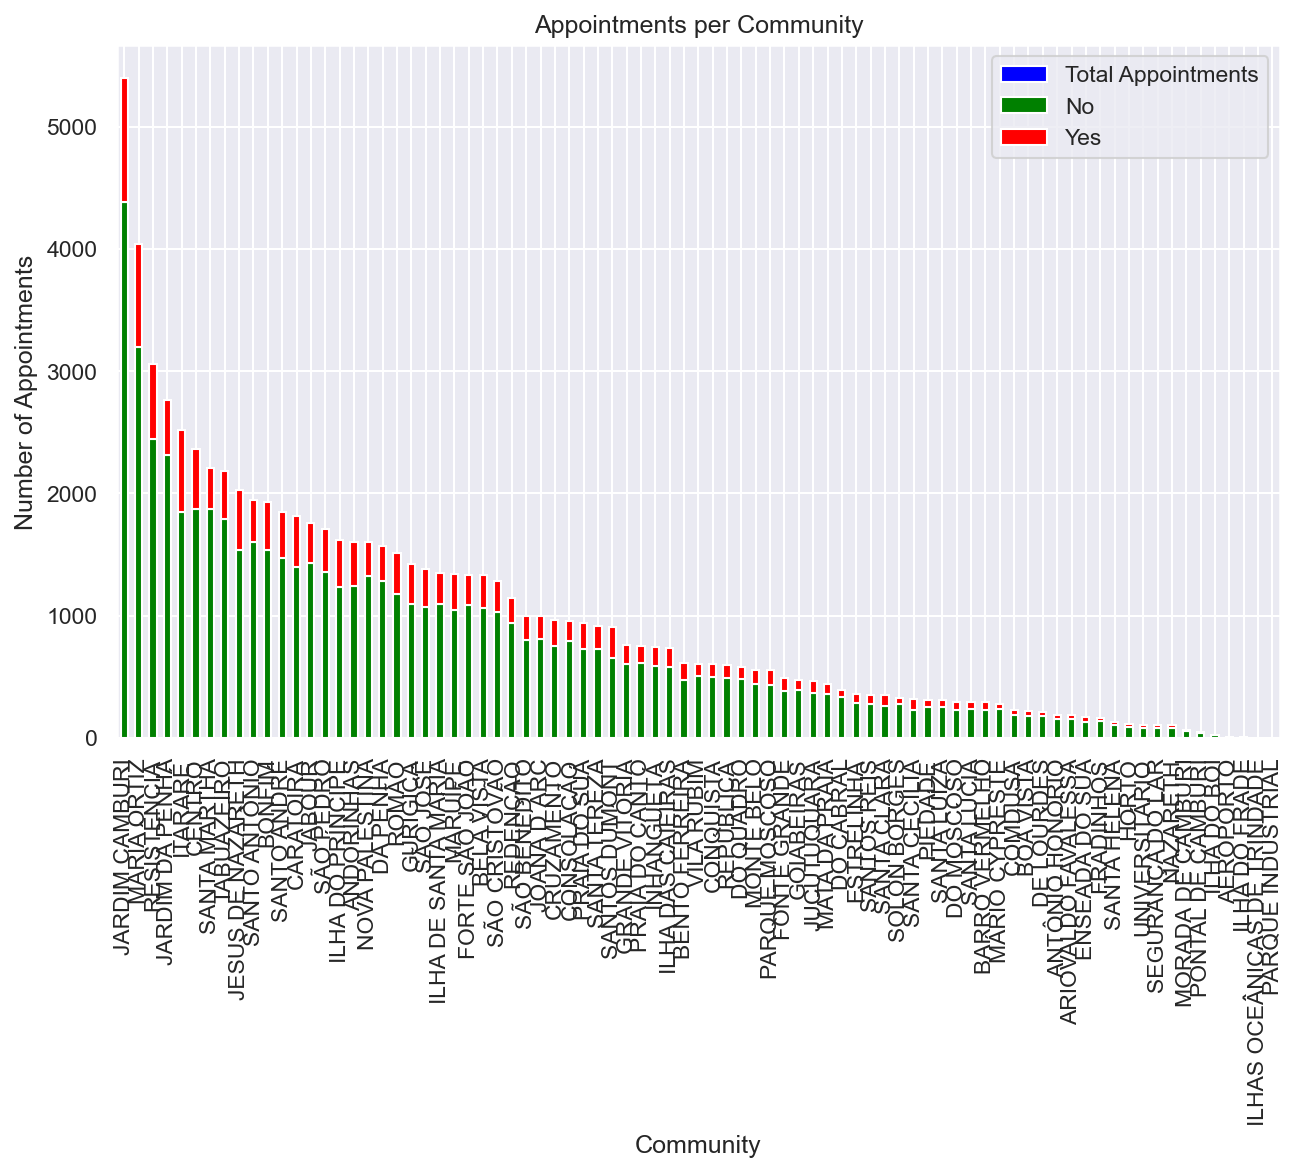

In [11]:

# Do patients of a certain community miss their appointments more than others?

# Count the total number of appointments per community
total_appointments_per_community = df['Community'].value_counts()

# Sort the DataFrame based on the total number of appointments
sorted_df = df[df['Community'].isin(total_appointments_per_community.index)].copy()
sorted_df['Community'] = pd.Categorical(sorted_df['Community'], categories=total_appointments_per_community.index, ordered=True)
sorted_df = sorted_df.sort_values(by=['Community'])

# Count the number of appointments per community split by show_up status
appointments_per_community_show_up = sorted_df.groupby(['Community', 'No-show']).size().unstack(fill_value=0)

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Bar chart for total appointments per community
total_appointments_per_community.loc[sorted_df['Community'].unique()].plot(kind='bar', ax=ax, color='blue', label='Total Appointments')

# Bar chart for appointments per community split by show_up status
appointments_per_community_show_up.plot(kind='bar', stacked=True, ax=ax, color=['green', 'red'], label=['Show Up', 'No Show Up'])

# Adding labels and legend
ax.set_title('Appointments per Community')
ax.set_xlabel('Community')
ax.set_ylabel('Number of Appointments')
ax.legend()

plt.show()

### 5. Data Cleaning and Preprocessing (incl. additional EDA)

- Dropping erroneous data
- Updating Existing Features: Get the columns into the right data types (has some errors but delayed due to non-urgency)
- Updating Existing Features: Handling Missing Data: Extrapolation + Imputation (?)
- Adding New Features: Time between ScheduledDate and AppointmentDate
- Standardization of Continuous variable: yes or no?
- OneHotEncoding for Categorical Vairables
- Feature Selection based on Correlation Matrix
- Feature Selection based on Information Gain
- Feature Selection based on Automated Methods i.e. SelectKBest()

In [12]:
# Keeping original df intact:

df_t = df[:]

In [13]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88421 entries, 0 to 88420
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PatientId        88421 non-null  float64
 1   AppointmentID    88421 non-null  int64  
 2   Sex              88421 non-null  object 
 3   ScheduledDate    88421 non-null  object 
 4   AppointmentDate  88421 non-null  object 
 5   Age              79614 non-null  float64
 6   Community        77708 non-null  object 
 7   SocialWelfare    75902 non-null  object 
 8   Hipertension     80400 non-null  object 
 9   Diabetes         88421 non-null  object 
 10  Alcoholism       73532 non-null  object 
 11  Handcap          88421 non-null  object 
 12  SMS_received     88421 non-null  object 
 13  No-show          88421 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 9.4+ MB


In [14]:
## Data Type Consistency

df_t.dtypes

PatientId          float64
AppointmentID        int64
Sex                 object
ScheduledDate       object
AppointmentDate     object
Age                float64
Community           object
SocialWelfare       object
Hipertension        object
Diabetes            object
Alcoholism          object
Handcap             object
SMS_received        object
No-show             object
dtype: object

In [15]:
# Dropping erroneous data

# Dropping inconsistent dates from transformed dataframe

df_t = df_t.drop(df[df['ScheduledDate'] > df['AppointmentDate']].index)


In [16]:
# Dropping outliers for Handcap: 2, 3, 4

df_t['Handcap'] = df_t['Handcap'][df_t['Handcap'].isin(['yes', 'no'])]

In [17]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88417 entries, 0 to 88420
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PatientId        88417 non-null  float64
 1   AppointmentID    88417 non-null  int64  
 2   Sex              88417 non-null  object 
 3   ScheduledDate    88417 non-null  object 
 4   AppointmentDate  88417 non-null  object 
 5   Age              79611 non-null  float64
 6   Community        77704 non-null  object 
 7   SocialWelfare    75899 non-null  object 
 8   Hipertension     80396 non-null  object 
 9   Diabetes         88417 non-null  object 
 10  Alcoholism       73529 non-null  object 
 11  Handcap          88264 non-null  object 
 12  SMS_received     88417 non-null  object 
 13  No-show          88417 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 10.1+ MB


In [18]:
occ = df_t.groupby('Handcap').size().reset_index()
print(occ)

  Handcap      0
0      no  86623
1     yes   1641


In [19]:
# PatientId and Age are to be converted to int from float as IDs must be int/str and ages are usually considered in whole number terms.

# Has an error!!!

# df_t["PatientId"] = pd.to_numeric(df["PatientId"], errors='coerce').astype(int)
# df_t["Age"] = pd.to_numeric(df["Age"], errors='coerce').astype(int)


In [20]:
# Extrapolating missing data

missing_columns = ['Age', 'Community', 'SocialWelfare', 'Hipertension', 'Alcoholism']

for column in missing_columns:
    df_t[column] = df_t.groupby('PatientId')[column].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


/var/folders/1z/kkxxkq_90qldq3ngyx1pj0fr0000gn/T/ipykernel_64289/1004969637.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_t[column] = df_t.groupby('PatientId')[column].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [21]:
missing_data = df_t.isnull().sum()
total_entries = len(df_t)
percentage_missing = round((missing_data / total_entries) * 100, 2)

missing_info = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage Missing': percentage_missing
})

print(missing_info)

                 Missing Count  Percentage Missing
PatientId                    0                0.00
AppointmentID                0                0.00
Sex                          0                0.00
ScheduledDate                0                0.00
AppointmentDate              0                0.00
Age                       3778                4.27
Community                 4631                5.24
SocialWelfare             5450                6.16
Hipertension              3406                3.85
Diabetes                     0                0.00
Alcoholism                6611                7.48
Handcap                    153                0.17
SMS_received                 0                0.00
No-show                      0                0.00


In [22]:
## Dropping missing values for time being. In the future we could also use the KNN imputer to fill empty values.

df_t.dropna(inplace=True)

In [23]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69168 entries, 0 to 88420
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PatientId        69168 non-null  float64
 1   AppointmentID    69168 non-null  int64  
 2   Sex              69168 non-null  object 
 3   ScheduledDate    69168 non-null  object 
 4   AppointmentDate  69168 non-null  object 
 5   Age              69168 non-null  float64
 6   Community        69168 non-null  object 
 7   SocialWelfare    69168 non-null  object 
 8   Hipertension     69168 non-null  object 
 9   Diabetes         69168 non-null  object 
 10  Alcoholism       69168 non-null  object 
 11  Handcap          69168 non-null  object 
 12  SMS_received     69168 non-null  object 
 13  No-show          69168 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 7.9+ MB


In [24]:
# Apprx loss of data

(1- (df_t.count()/ df.count())) * 100

PatientId          21.774239
AppointmentID      21.774239
Sex                21.774239
ScheduledDate      21.774239
AppointmentDate    21.774239
Age                13.120808
Community          10.989859
SocialWelfare       8.871966
Hipertension       13.970149
Diabetes           21.774239
Alcoholism          5.934831
Handcap            21.774239
SMS_received       21.774239
No-show            21.774239
dtype: float64

In [25]:
df_t.dtypes

PatientId          float64
AppointmentID        int64
Sex                 object
ScheduledDate       object
AppointmentDate     object
Age                float64
Community           object
SocialWelfare       object
Hipertension        object
Diabetes            object
Alcoholism          object
Handcap             object
SMS_received        object
No-show             object
dtype: object

In [26]:
# Adding New Features: Time between ScheduledDate and AppointmentDate

from datetime import timedelta

df_t['time_bw_schedule_appointment'] = df_t['AppointmentDate'] - df_t['ScheduledDate']

## Convert to float (days)

df_t['time_bw_schedule_appointment'] = df_t['time_bw_schedule_appointment'] / pd.Timedelta(days=1)
df_t['time_bw_schedule_appointment'] = df_t['time_bw_schedule_appointment'].astype(float)



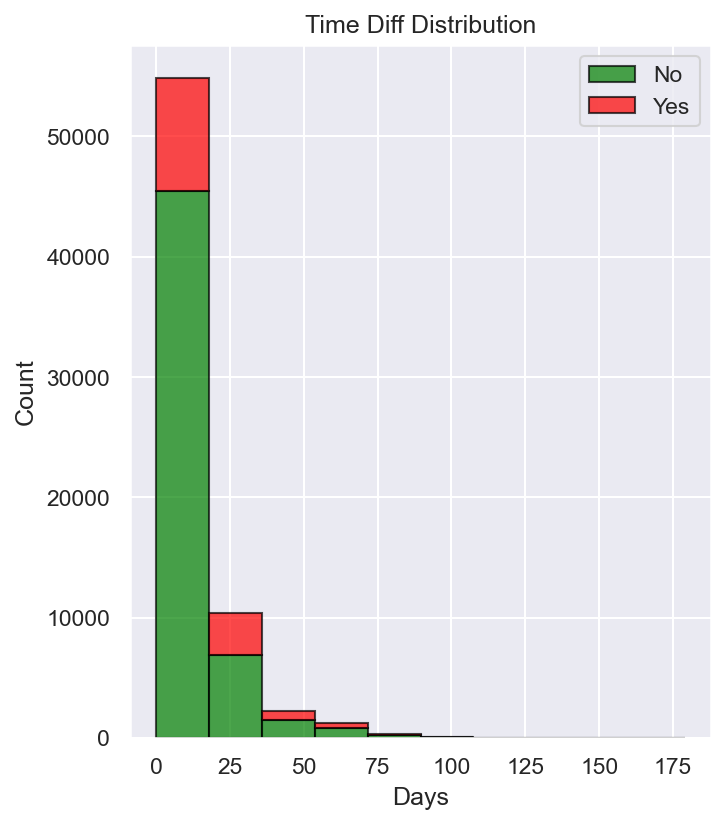

In [27]:
# Plot histogram with split bars ## EDA and can be removed later.

plt.hist([df_t[df_t['No-show'] == 'No']['time_bw_schedule_appointment'], df_t[df_t['No-show'] == 'Yes']['time_bw_schedule_appointment']],
         bins=10, color=['green', 'red'], alpha=0.7, edgecolor='black', label=['No', 'Yes'], stacked=True)

plt.title('Time Diff Distribution')
plt.xlabel('Days')
plt.ylabel('Count')
plt.legend()

plt.show()

In [28]:
# Take relevant columns for correlation matrix

df_sub = df_t[['Diabetes', 'Sex', 'Alcoholism', 'Hipertension', 'SMS_received', 'Handcap', 'time_bw_schedule_appointment', 'No-show']]

<Axes: >

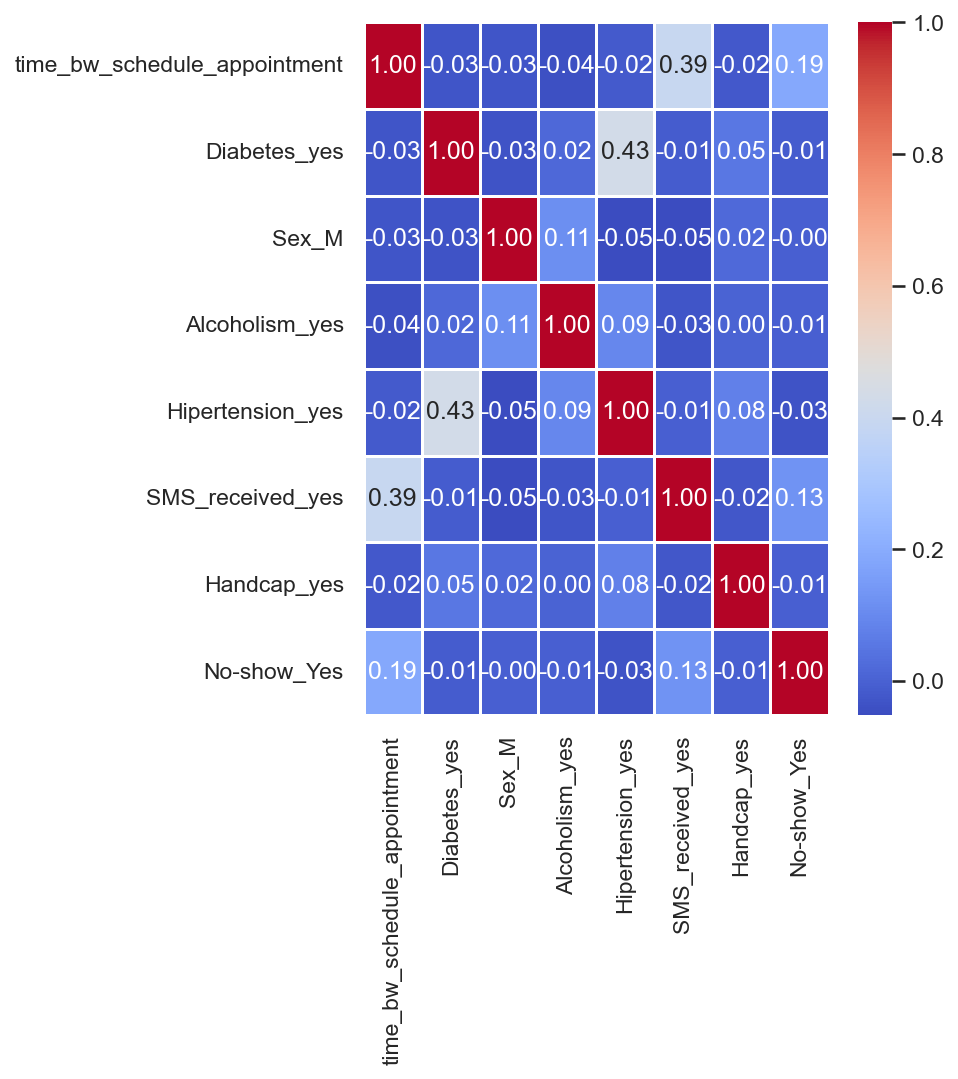

In [29]:
# Feature Selection: Correlation Matrix to understand which features have highest correlation with target variable and less correlation amongst each other.

df_t_encoded = pd.get_dummies(df_sub, columns=['Diabetes', 'Sex', 'Alcoholism', 'Hipertension', 'SMS_received', 'Handcap', 'No-show'], drop_first=True).astype(int)
correlation_matrix = df_t_encoded.corr()

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)

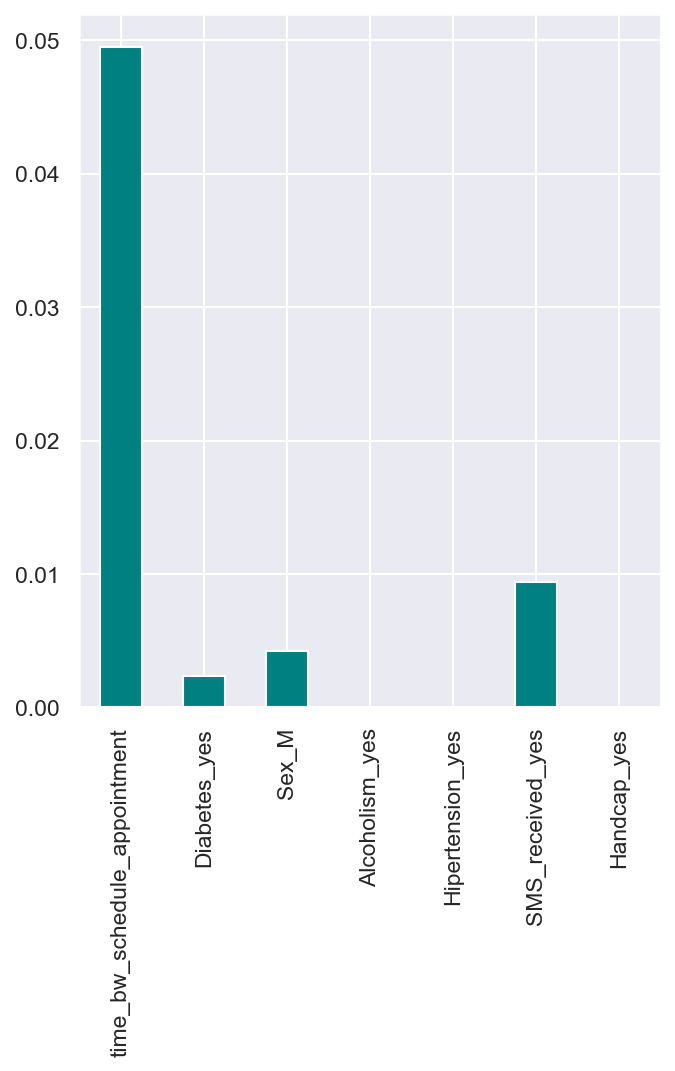

In [30]:
# Feature Selection based on Info Gain

from sklearn.feature_selection import mutual_info_classif

X = df_t_encoded.drop("No-show_Yes", axis=1)
y = df_t_encoded['No-show_Yes']

importances = mutual_info_classif(X, y)
feature_importances = pd.Series(importances, df_t_encoded.columns[0:len(df_t_encoded.columns)-1])
feature_importances.plot(kind="bar", color="teal")
plt.show()

In [31]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression, f_classif
from numpy import array

# Create training set and prediction target
X = df_t_encoded.drop("No-show_Yes", axis=1)
y = df_t_encoded['No-show_Yes']

# Perform feature selection
# Set k to the number of features you want to identify
select = SelectKBest(score_func=f_classif, k=4)
select.fit_transform(X,y)

# Print feature names
filter = select.get_support() 
features = array(X.columns)
 
print("Selected best:")
print(features[filter])

Selected best:
['time_bw_schedule_appointment' 'Diabetes_yes' 'Hipertension_yes'
 'SMS_received_yes']


In [32]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69168 entries, 0 to 88420
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PatientId                     69168 non-null  float64
 1   AppointmentID                 69168 non-null  int64  
 2   Sex                           69168 non-null  object 
 3   ScheduledDate                 69168 non-null  object 
 4   AppointmentDate               69168 non-null  object 
 5   Age                           69168 non-null  float64
 6   Community                     69168 non-null  object 
 7   SocialWelfare                 69168 non-null  object 
 8   Hipertension                  69168 non-null  object 
 9   Diabetes                      69168 non-null  object 
 10  Alcoholism                    69168 non-null  object 
 11  Handcap                       69168 non-null  object 
 12  SMS_received                  69168 non-null  object 
 13  No-sho

In [33]:
df_t = df_t.applymap(lambda x: x.capitalize() if isinstance(x, str) else x)

/var/folders/1z/kkxxkq_90qldq3ngyx1pj0fr0000gn/T/ipykernel_64289/4270060669.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_t = df_t.applymap(lambda x: x.capitalize() if isinstance(x, str) else x)


### 6. Train-Test Split

In [34]:
from sklearn.model_selection import train_test_split

X = df_t.drop(columns=['No-show', 'PatientId', 'AppointmentID', 'ScheduledDate', 'AppointmentDate', 'Community'])
y = df_t['No-show']

from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [35]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69168 entries, 0 to 88420
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PatientId                     69168 non-null  float64
 1   AppointmentID                 69168 non-null  int64  
 2   Sex                           69168 non-null  object 
 3   ScheduledDate                 69168 non-null  object 
 4   AppointmentDate               69168 non-null  object 
 5   Age                           69168 non-null  float64
 6   Community                     69168 non-null  object 
 7   SocialWelfare                 69168 non-null  object 
 8   Hipertension                  69168 non-null  object 
 9   Diabetes                      69168 non-null  object 
 10  Alcoholism                    69168 non-null  object 
 11  Handcap                       69168 non-null  object 
 12  SMS_received                  69168 non-null  object 
 13  No-sho

In [36]:
# One Hot Encoding of Categorical Variables

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False, drop='if_binary')

ct = ColumnTransformer(
    [('OneHotEncoder', ohe, ['SocialWelfare', 'Diabetes', 'Sex', 'Alcoholism', 'Hipertension', 'SMS_received', 'Handcap'])],
    remainder='passthrough'
)

ct.fit_transform(X_train)

array([[ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., 48., 25.],
       [ 0.,  0.,  1., ...,  0., 50.,  5.],
       ...,
       [ 0.,  0.,  1., ...,  0., 96.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0., 41.],
       [ 0.,  0.,  1., ...,  1., 35.,  5.]])

In [37]:
x = ct.fit_transform(X_train)

df_X = pd.DataFrame(x)

print(df_X)

         0    1    2    3    4    5    6     7     8
0      0.0  0.0  1.0  0.0  0.0  0.0  0.0   0.0   0.0
1      0.0  0.0  0.0  0.0  0.0  1.0  0.0  48.0  25.0
2      0.0  0.0  1.0  0.0  0.0  0.0  0.0  50.0   5.0
3      0.0  1.0  0.0  0.0  1.0  0.0  0.0  83.0   0.0
4      1.0  0.0  0.0  0.0  0.0  0.0  0.0   7.0  13.0
...    ...  ...  ...  ...  ...  ...  ...   ...   ...
55329  0.0  0.0  1.0  0.0  0.0  1.0  0.0  50.0   4.0
55330  0.0  0.0  0.0  0.0  0.0  1.0  0.0  60.0  33.0
55331  0.0  0.0  1.0  0.0  1.0  0.0  0.0  96.0   0.0
55332  0.0  0.0  1.0  0.0  0.0  0.0  0.0   0.0  41.0
55333  0.0  0.0  1.0  0.0  0.0  1.0  1.0  35.0   5.0

[55334 rows x 9 columns]


### 7. Model Building


In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

clf = DecisionTreeClassifier()

# Create pipeline
pipe = Pipeline([
    ('preprocessor', ct),
    ('classifier', clf)]
)

In [39]:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHotEncoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['SocialWelfare', 'Diabetes',
                                                   'Sex', 'Alcoholism',
                                                   'Hipertension',
                                                   'SMS_received',
                                                   'Handcap'])])),
                ('classifier', DecisionTreeClassifier())])

In [40]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHotEncoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['SocialWelfare', 'Diabetes',
                                                   'Sex', 'Alcoholism',
                                                   'Hipertension',
                                                   'SMS_received',
                                                   'Handcap'])])),
                ('classifier', DecisionTreeClassifier())])

In [41]:
y_pred = pipe.predict(X_test)

### 8. Model Evaluation

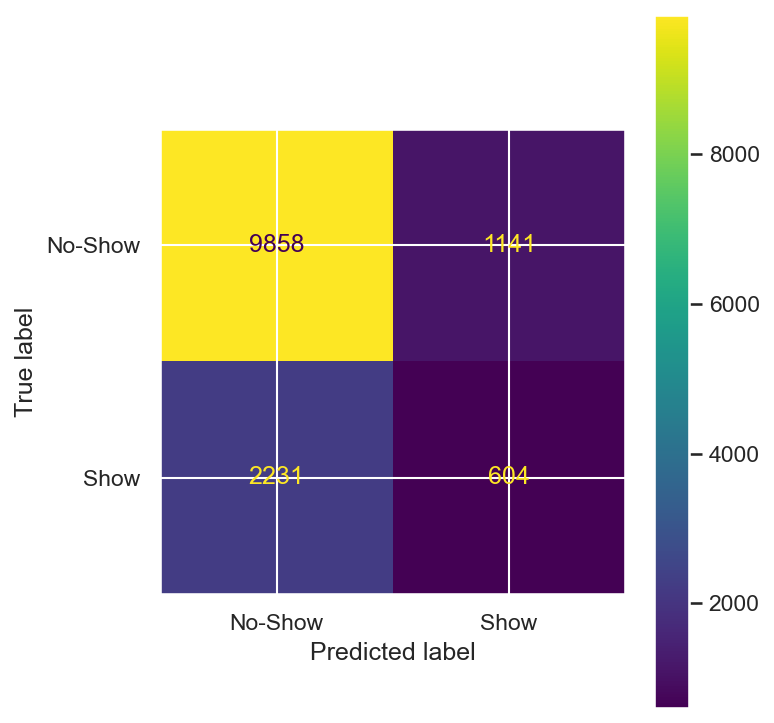

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

display_labels=['No-Show', 'Show']
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=display_labels)
disp.plot()
plt.show()

In [43]:
# Print a classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.85     10999
           1       0.35      0.21      0.26      2835

    accuracy                           0.76     13834
   macro avg       0.58      0.55      0.56     13834
weighted avg       0.72      0.76      0.73     13834



## This is the processing for test.

In [44]:
# Keeping original df intact:

df_test = pd.read_csv('/Users/muhammadraza/Documents/GitHub/BIPM/Data Science/Project/test.csv')

df_test_t = df_test[:]

In [45]:
df_test_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22106 entries, 0 to 22105
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PatientId        22106 non-null  float64
 1   AppointmentID    22106 non-null  int64  
 2   Sex              22106 non-null  object 
 3   ScheduledDate    22106 non-null  object 
 4   AppointmentDate  22106 non-null  object 
 5   Age              19955 non-null  float64
 6   Community        19461 non-null  object 
 7   SocialWelfare    19043 non-null  object 
 8   Hipertension     20089 non-null  object 
 9   Diabetes         22106 non-null  object 
 10  Alcoholism       18371 non-null  object 
 11  Handcap          22106 non-null  object 
 12  SMS_received     22106 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.2+ MB


In [46]:
## Data Type Consistency

df_test_t.dtypes

PatientId          float64
AppointmentID        int64
Sex                 object
ScheduledDate       object
AppointmentDate     object
Age                float64
Community           object
SocialWelfare       object
Hipertension        object
Diabetes            object
Alcoholism          object
Handcap             object
SMS_received        object
dtype: object

In [47]:
# Dropping erroneous data

# No need to change dates.

In [48]:
# Dropping outliers for Handcap: 2, 3, 4

import numpy as np

df_test_t['Handcap'] = np.where(df_test_t['Handcap'] != 'yes', 'no', df_test_t['Handcap'])

In [49]:
df_test_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22106 entries, 0 to 22105
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PatientId        22106 non-null  float64
 1   AppointmentID    22106 non-null  int64  
 2   Sex              22106 non-null  object 
 3   ScheduledDate    22106 non-null  object 
 4   AppointmentDate  22106 non-null  object 
 5   Age              19955 non-null  float64
 6   Community        19461 non-null  object 
 7   SocialWelfare    19043 non-null  object 
 8   Hipertension     20089 non-null  object 
 9   Diabetes         22106 non-null  object 
 10  Alcoholism       18371 non-null  object 
 11  Handcap          22106 non-null  object 
 12  SMS_received     22106 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.2+ MB


In [50]:
# Extrapolating missing data

missing_columns = ['Age', 'Community', 'SocialWelfare', 'Hipertension', 'Alcoholism']

for column in missing_columns:
    df_test_t[column] = df_test_t.groupby('PatientId')[column].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


/var/folders/1z/kkxxkq_90qldq3ngyx1pj0fr0000gn/T/ipykernel_64289/1740001506.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_test_t[column] = df_test_t.groupby('PatientId')[column].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [51]:
df_test_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22106 entries, 0 to 22105
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PatientId        22106 non-null  float64
 1   AppointmentID    22106 non-null  int64  
 2   Sex              22106 non-null  object 
 3   ScheduledDate    22106 non-null  object 
 4   AppointmentDate  22106 non-null  object 
 5   Age              20559 non-null  float64
 6   Community        20131 non-null  object 
 7   SocialWelfare    19805 non-null  object 
 8   Hipertension     20625 non-null  object 
 9   Diabetes         22106 non-null  object 
 10  Alcoholism       19280 non-null  object 
 11  Handcap          22106 non-null  object 
 12  SMS_received     22106 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.2+ MB


In [52]:
# Adding New Features: Time between ScheduledDate and AppointmentDate

from datetime import timedelta

from datetime import datetime

df_test_t['AppointmentDate'] = df_test_t['AppointmentDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').date())
df_test_t['ScheduledDate'] = df_test_t['ScheduledDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').date())


In [53]:

df_test_t['time_bw_schedule_appointment'] = df_test_t['AppointmentDate'] - df_test_t['ScheduledDate']

## Convert to float (days)

df_test_t['time_bw_schedule_appointment'] = df_test_t['time_bw_schedule_appointment'] / pd.Timedelta(days=1)
df_test_t['time_bw_schedule_appointment'] = df_test_t['time_bw_schedule_appointment'].astype(float)



In [54]:
# Take relevant columns for correlation matrix

df_sub_test = df_test_t[['Diabetes', 'Sex', 'Alcoholism', 'Hipertension', 'SMS_received', 'Handcap', 'time_bw_schedule_appointment']]

In [55]:
df_test_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22106 entries, 0 to 22105
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PatientId                     22106 non-null  float64
 1   AppointmentID                 22106 non-null  int64  
 2   Sex                           22106 non-null  object 
 3   ScheduledDate                 22106 non-null  object 
 4   AppointmentDate               22106 non-null  object 
 5   Age                           20559 non-null  float64
 6   Community                     20131 non-null  object 
 7   SocialWelfare                 19805 non-null  object 
 8   Hipertension                  20625 non-null  object 
 9   Diabetes                      22106 non-null  object 
 10  Alcoholism                    19280 non-null  object 
 11  Handcap                       22106 non-null  object 
 12  SMS_received                  22106 non-null  object 
 13  t

In [56]:
df_test_t = df_test_t.applymap(lambda x: x.capitalize() if isinstance(x, str) else x)

/var/folders/1z/kkxxkq_90qldq3ngyx1pj0fr0000gn/T/ipykernel_64289/1034764883.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_test_t = df_test_t.applymap(lambda x: x.capitalize() if isinstance(x, str) else x)


In [57]:
X_df_test = df_test_t.drop(columns=['PatientId', 'AppointmentID', 'ScheduledDate', 'AppointmentDate', 'Community'])

X_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22106 entries, 0 to 22105
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Sex                           22106 non-null  object 
 1   Age                           20559 non-null  float64
 2   SocialWelfare                 19805 non-null  object 
 3   Hipertension                  20625 non-null  object 
 4   Diabetes                      22106 non-null  object 
 5   Alcoholism                    19280 non-null  object 
 6   Handcap                       22106 non-null  object 
 7   SMS_received                  22106 non-null  object 
 8   time_bw_schedule_appointment  22106 non-null  float64
dtypes: float64(2), object(7)
memory usage: 1.5+ MB


In [58]:
from sklearn.impute import SimpleImputer

imputer_cont = SimpleImputer(strategy="median", add_indicator=False)
imputer_cat = SimpleImputer(strategy="most_frequent", add_indicator=False)

ct_test = ColumnTransformer(
    [('impute_age', imputer_cont, ['Age']),
    ('impute_cat', imputer_cat, ['SocialWelfare', 'Diabetes','Alcoholism', 'Hipertension'])],
    remainder='passthrough'
)

ct_output = ct_test.fit_transform(X_df_test)

ct_test.get_feature_names_out()

columnsImp = ["Age","SocialWelfare",'Diabetes','Alcoholism', 'Hipertension','Sex', 'Handcap',  'SMS_received', 'time_bw_schedule_appointment']
ct_df = pd.DataFrame(ct_output, columns= columnsImp)
ct_df.head()

## Has 9 columns as expected

,Age,SocialWelfare,Diabetes,Alcoholism,Hipertension,Sex,Handcap,SMS_received,time_bw_schedule_appointment
0,30.0,No,No,No,No,F,No,Yes,14.0
1,51.0,No,No,No,No,M,No,No,1.0
2,37.0,No,No,No,No,M,No,No,2.0
3,62.0,No,No,No,No,M,No,Yes,20.0
4,69.0,No,No,No,No,M,No,Yes,21.0


In [62]:
ohe = OneHotEncoder(sparse_output=False, drop='first')

ct = ColumnTransformer(
    [('OneHotEncoder', ohe, ['SocialWelfare', 'Diabetes', 'Sex', 'Alcoholism', 'Hipertension', 'SMS_received', 'Handcap'])],
    remainder='passthrough'
)
ct.fit_transform(ct_df)

ct.get_feature_names_out()

array(['OneHotEncoder__SocialWelfare_Yes', 'OneHotEncoder__Diabetes_Yes',
       'OneHotEncoder__Sex_M', 'OneHotEncoder__Alcoholism_Yes',
       'OneHotEncoder__Hipertension_Yes',
       'OneHotEncoder__SMS_received_Yes', 'OneHotEncoder__Handcap_Yes',
       'remainder__Age', 'remainder__time_bw_schedule_appointment'],
      dtype=object)

In [63]:
y_pred_test = pipe.predict(ct_df)

In [64]:
df_test["No-Show"] = y_pred_test
mapping = {0: 'No', 1: 'Yes'}
df_test["No-show"] = df_test["No-Show"].replace(mapping)
Submission = df_test[["AppointmentID", "No-show"]]
Submission.head()

,AppointmentID,No-show
0,5620835,No
1,5741692,No
2,5673005,Yes
3,5579701,No
4,5652332,No


### 9. Model Interpretation


### 10. Fine-Tuning and Optimization